# Variant Call Adjacency Matrix


In the modern era of Genomics and Bioinformatics, tools are being created to interpret large scale genomic data. One such common comparison between two individual's is to compute a person's allele frequency through identifying their genomic variants. This notebook demonstrates an alternative approach to interpreting genomic variants through data visualization. 

The GA4GH variant service is used to produce an interconnected matrix of variants from data in 1000 genomes.

Further analysis of specific populations in the 1000 genomes dataset is performed. 

The machine learning algorithm, K-means clustering on the variant matrix is performed. 

# GA4GH Server Connection is Established

A client object is used to communicate with the GA4GH server and helpful modules are imported. 

In [69]:
from __future__ import print_function
import ga4gh.client.client as client
client = client.HttpClient("http://1kgenomes.ga4gh.org")

import collections
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import ImageGrid
from numpy.random import RandomState
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import unirest
import requests 
import json
from multiprocessing import Pool
from finch import *
import operator
import random 

# The 1000 Genomes Dataset is Chosen

In [70]:
datasets = list(client.search_datasets())

# get 1000 gneomes dataset 
dataset = client.get_dataset(datasets[0].id)

release = None
functional = None
for variant_set in client.search_variant_sets(dataset_id=dataset.id):
    if variant_set.name == "phase3-release":
        release = variant_set
    else:
        functional = variant_set

callsi = list(client.search_call_sets(release.id))

variant_sets = list(client.search_variant_sets(dataset.id))
variant_set_id = variant_sets[0].id

call_set_ids = []

for csi in callsi:        
    call_set_ids.append(csi.id)

# Population Groups are Mapped to Respective Call Set Ids 

In [71]:
def map_call_set_ids_to_population_group():
    """
    This allows for the individuals being analyzed to be identified based on 1000 genomes population group. 
    """
    population_map = {}
     
    for call_set in client.search_call_sets(release.id):
        
        bio_sample = client.get_bio_sample(call_set.bio_sample_id)
        population_map[call_set.id] = bio_sample.info['Population'].values[0].string_value 
    
    
    return population_map

# generate_dictionary()

In [73]:
def generate_dictionary(num_people, num_chrom, begin, stop):
    """
    This function generates a dictionary of call set id keys and values for the index 
    that the call set id appeared in throughout a list of variants within a given range on the human genome.
   
    num_people - the number of people to analyze
    num_chrom - the chromosome number
    begin - the start position on the genome
    stop - the end position on the genome 
    """
    dictionary = {}
    
    variants = client.search_variants(variant_set_id, call_set_ids= call_set_ids[0:num_people],
           start=begin, end=stop, reference_name = num_chrom )
    
    i = 0
    for v in variants:
        for call_inner in v.calls:
            i += 1
            dictionary[call_inner.call_set_id] = i
    
    return (dictionary)  

# normalize_indexes()

In [74]:
def normalize_indexes(dictionary):
    """
    initializes the indexes of the variant dictionay to be {0,...,n} where n is the number of call set ids 
    
    dictionary - call set id keys, call set id index values 
    """
    keys = []
    keys = dictionary.keys()
    
    new_dictionary = {}
    i = 0
    j = 0
    k = 0
    for i in range(len(dictionary)):        
        l = keys[j]
        dictionary[l] = k
        j += 1
        k += 1
    
    return dictionary

# variant_matrix()

This function connects two identical sets of participant sample's callSetId's through the variants shared between them.

                     M D (Mother/Father allele donated)
    Where A or B =  [1,0] : heterozygous for variant
                    [0,1] : heterozygous for variant
                    [1,1] : homozygous dominant for variant
                    [0,0] : homozygous recessive for variant
                 
        | 1    |  0    |
      1 |[1,1] | [1,0] |
        |      |       |      
      0 |[1,0] | [0,0] |
    
    
    True for the shared genotype:
        
        case 1: 
            A = [1,0]
            B = [0,1]
        case 2: 
            A = [0,0]
            B = [0,0]
        case 3:  
            A = [1,0]
            B = [1,0]
        case 4: 
            A = [1,1]
            B = [0,1]
    
    False for the shared genotype:
        
        case 1: 
            A = [1,0]
            B = [0,0]
        case 2:
            A = [0,1]
            B = [0,0]
        case 3: 
            A = [0,0]
            B = [1,0]
        case 4:
            A = [0,0]
            B = [0,1]
            
            

In [75]:
def variant_matrix(num_people, num_chrom, begin, stop):
    """
    num_people - the number of people to analyze
    num_chrom - the chromosome number
    begin - the start position on the genome
    stop - the end position on the genome 
    """    
    
    # get dictionary of call set ids for the number of people 
    csid_dict = {}    
    csid_dict = generate_dictionary(num_people, num_chrom, begin, stop)
    
    normalize_indexes(csid_dict)
    
    h = len(csid_dict)
    w = len(csid_dict)
    dimension = h*w
    
    # initialize callMatrix with zeroes 
    callMatrix = {}
    callMatrix = [[0 for x in range(w)] for y in range(h)]    
    np.zeros((h,w))     
    
    vs = client.search_variants(variant_set_id, call_set_ids= call_set_ids[0:num_people],
           start=begin, end=stop, reference_name = num_chrom)
    
    # iterate through each persons call set id and increment cells in the matrix for shared genotypes 
    for v in vs:
        for call_outer in v.calls: 
            for call_inner in v.calls:
                outer_index = csid_dict[call_outer.call_set_id] 
                inner_index = csid_dict[call_inner.call_set_id]                             
                # can be 0 or 1
                A1 = call_outer.genotype[0] 
                A2 = call_outer.genotype[1]
                B1 = call_inner.genotype[0]
                B2 = call_inner.genotype[1]               
                # True for the shared genotype
                if (((A1 + A2 ) > 0) and ((B1 + B2) > 0)):
                    callMatrix[outer_index][inner_index] += 1

                elif (((A1 + A2 ) == 0) and ((B1 + B2) == 0)):
                    callMatrix[outer_index][inner_index] += 1
                   
    return (callMatrix)

# visualize_matrix functions 

In [76]:
def visualize_matrix_color(num_people, num_chrom, begin, stop):
    
    """
    visualizes the matrix in rgb color
    
    num_people - the number of people to analyze
    num_chrom - the chromosome number
    begin - the start position on the genome
    stop - the end position on the genome 
    """
    
    callMatrix = variant_matrix(num_people, num_chrom, begin, stop)
    
    fig = plt.figure(1,(10.,10.))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(1,1),
                    axes_pad=0.1)
    
    ax = grid[0]
    ax.set_title('Color matrix comparing the occurence of shared variants obtained from call set ids between individuals in the the genomic dataset\n', fontsize=14, fontweight='bold')
    ax.set_xlabel("Individual's call set ids", fontsize=12)
    ax.set_ylabel("Individual's call set ids", fontsize=12)    
    ax.imshow(callMatrix, origin = "lower", interpolation="nearest")
    
    plt.show()

def visualize_matrix_grey(num_people, num_chrom, begin, stop):
    """
    visualizes the matrix in greyscale color
    
    num_people - the number of people to analyze
    num_chrom - the chromosome number
    begin - the start position on the genome
    stop - the end position on the genome 
    """
        
    callMatrix = variant_matrix(num_people, num_chrom, begin, stop)
       
    fig = plt.figure(1,(10.,10.))
   
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(1,1),
                    axes_pad=0.1)
    ax = grid[0]  
    ax.set_title('Greyscale matrix comparing the occurence of shared variants obtained from call set ids between individuals in the the genomic dataset\n', fontsize=14, fontweight='bold')
    ax.set_xlabel("Individual's call set ids", fontsize=12)
    ax.set_ylabel("Individual's call set ids", fontsize=12)
    
    ax.imshow(callMatrix, cmap= 'Greys', origin = "lower", interpolation="nearest")
    
 
    plt.show()

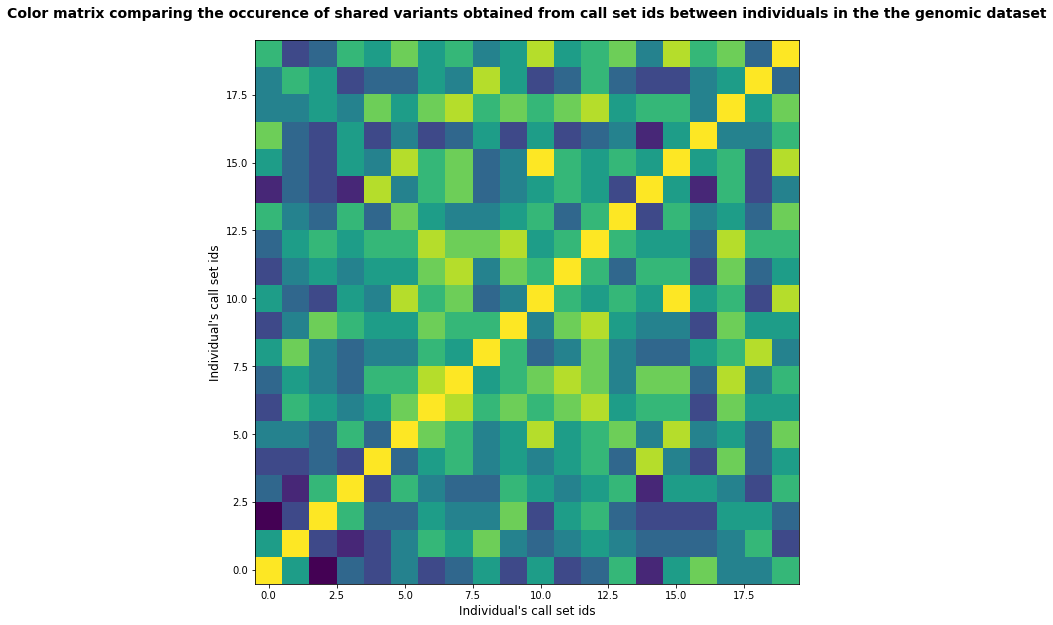

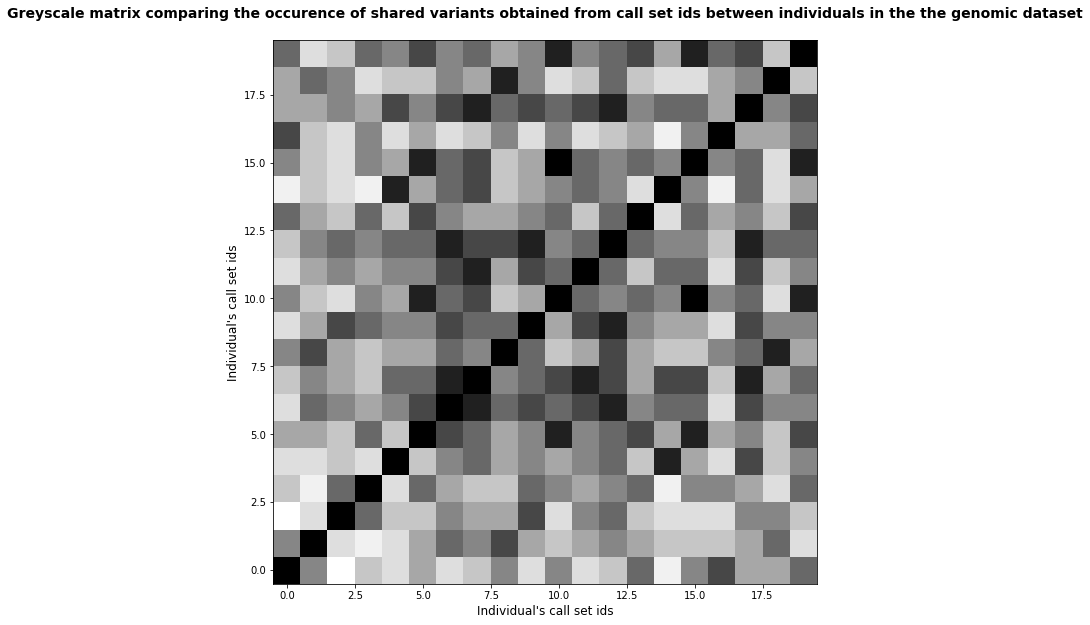

In [77]:
visualize_matrix_color(20, "1", 10000, 15000)
visualize_matrix_grey(20, "1", 10000, 15000)

# k_means_clustering_on_variant_matrix()

In [87]:
def k_means_clustering_on_variant_matrix(num_people, num_chrom, begin, stop, clusters):
    """
    returns a list of labels given by the k-means clustering algorithm which indicate which 
    individuals should be clustered together 
    
    num_people - the number of people to analyze
    num_chrom - the chromosome number
    begin - the start position on the genome
    stop - the end position on the genome 
    clusters - the number of clusters to form with this run on kmeans 
    """
    
    # number of individuals ()
    N = num_people
    # randomization
    rand = RandomState(1123581321) 
    # matrix generation 
    callMatrix = {}
    callMatrix = variant_matrix(N, num_chrom, begin, stop)
    # initialize KMeans clustering object
    kmeans_obj = KMeans(n_clusters=clusters, n_init=10, 
                    init='k-means++', precompute_distances=True,
                    tol=1e-4, random_state= rand)
    # Compute clustering and transform matrix to cluster-distance space. 
    labels = kmeans_obj.fit_predict(callMatrix)
    
    label_list = []
    for i in labels:
        label_list.append(i)
        
    return label_list

In [90]:
def assign_labels_to_indexes(num_people, num_chrom, begin, stop, clusters):
    
    """
    assigns the labels from the kmeans clustering to the individuals in a variant matrix 
    
    num_people - the number of people to analyze
    num_chrom - the chromosome number
    begin - the start position on the genome
    stop - the end position on the genome 
    clusters - the number of clusters to form with this run on kmeans 
    
    returns a dictionary of call set id keys, (label, matrix index( individual )) pairs values 
    """
    
    label_list = k_means_clustering_on_variant_matrix(num_people, 
                                                      num_chrom, begin, stop, clusters)
    dictionary = generate_dictionary(num_people, num_chrom, begin, stop) 
    dictionary = normalize_indexes(dictionary)
    
    i = 0
    j = 0
    k = 0
    label_index_dict = {}
    label_index_pair_list = []
    for i in label_list:
        pair = (i,j)
        label_index_pair_list.append(pair)
        j += 1
    
    
    label_index_pair_list.sort()

    i=0
    j=0
    k=0
    for i,j in dictionary.items():
        l = label_index_pair_list[k]
        dictionary[i] =l
        k += 1   
    
    return (dictionary)

In [123]:
def compare():
    
    """
    compares populations with the labels that they have been assigned to 
    
    returns population occurences 
    """
    
    matrix = {}
    label_dictionary = {}
    population_dictionary= {}
    
    label_dictionary = assign_labels_to_indexes(50, "1", 100000, 200000, 6)
    population_dictionary = map_call_set_ids_to_population_group()
    
    population_occurence = []
    
    for ld_key, ld_val in label_dictionary.iteritems():
        for pd_key, pd_val in population_dictionary.iteritems():
            if ( ld_key == pd_key):        
                #print ("Population: {} has cluster {}".format(pd_val, ld_val[0]))
                population_occurence.append((pd_val, ld_val[0]))
  
    
    return population_occurence

In [124]:
def map_populations():
    
    """
    maps populations to there clusters 
    returns a dictionary of population keys
    """
    
    population_cluster_list = []
    population_cluster_list = compare()
    
    i = 0
    j = 0
    population_dict = {}
    for i in population_cluster_list:
        population_dict[i[0]] = 0
    
    
    for i in population_cluster_list:
        if ( i[0] in population_dict):
            population_dict[i[0]] += 1
        
    return population_dict
    

In [125]:
def map_clusters():
    
    """
    maps clusters to there populations 
    returns a dictionary of population keys  
    """
    
    population_cluster_list = []
    population_cluster_list = compare()
    
    i = 0
    j = 0
    population_dict = {}
    for i in population_cluster_list:
        population_dict[i[1]] = 0
    
    for i in population_cluster_list:
        if ( i[1] == j):
            population_dict[i[1]] += 1
        else:
            population_dict[i[1]] += 1
            j += 1
    return population_dict

In [133]:
def map_a_dictionary(dictionary):
    
    plt.bar(range(len(dictionary)), dictionary.values(), align='center')
    plt.xticks(range(len(dictionary)), dictionary.keys())
    
    ax = fig.add_subplot(111)
    ax.set_title('Distribution of shared variants among the genomic dataset (as compared to the reference genome)\n', fontsize=14, fontweight='bold')
    ax.set_xlabel('number of shared variants called within a range of bases on one chromosome')
    ax.set_ylabel('percent occurence of the amount of shared variants')
    plt.show()

In [134]:
def graph_populations():
    
    population_dict = map_populations()
    
    fig = plt.figure(1,(10.,10.))

    plt.bar(range(len(population_dict)), population_dict.values(), align='center')
    plt.xticks(range(len(population_dict)), population_dict.keys())
    
    ax = fig.add_subplot(111)
    ax.set_title('Distribution of populations in dataset\n', fontsize=14, fontweight='bold')
    ax.set_xlabel('Population')
    ax.set_ylabel('Occurence count')
    plt.show()
    

In [135]:
def graph_clusters():
    
    cluster_dict = map_clusters()
    
    fig = plt.figure(1,(10.,10.))

    plt.bar(range(len(cluster_dict)),  cluster_dict.values(), align='center', color='r')
    plt.xticks(range(len(cluster_dict)),  cluster_dict.keys())
    
    ax = fig.add_subplot(111)
    ax.set_title('Distribution of clusters in the kmeans quantification\n', fontsize=14, fontweight='bold')
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Occurence count')
    plt.show()

In [136]:
def cluster_occurence():
    
    population_cluster_list = []
    population_cluster_list = compare()
    
    population_occurence_dict = {}   
    for i in population_cluster_list:
        population_occurence_dict[i] = 0
    
    i = 0
    j = 0
    for i in (population_cluster_list):
        if ( i[1] == j and i in population_occurence_dict):
            population_occurence_dict[i] += 1
        else:
            population_occurence_dict[i] += 1
            j += 1
        
    return population_occurence_dict
    

In [137]:
def normalize_cluster_occurence(pop_size):
    
    population_occurence_dict = cluster_occurence()
    
    poercent = 0.0
    for i ,j in population_occurence_dict.iteritems():
        percent = (float(j)/float(pop_size))*100.0
        population_occurence_dict[i] = percent
    
    return population_occurence_dict
        

In [138]:
def graph_cluster_occurence():
    
    """
    graphs the occurences of the clusters in each population 
    """
    
    population_occurence_dict = normalize_cluster_occurence(50)
    
    fig = plt.figure(1,(38.,8.))

    plt.bar(range(len(population_occurence_dict)),  population_occurence_dict.values(), align='center', color='g')
    plt.xticks(range(len(population_occurence_dict)),  population_occurence_dict.keys())
    
    ax = fig.add_subplot(111)
    ax.set_title('Distribution of clusters in the kmeans quantification\n', fontsize=14, fontweight='bold')
    ax.set_xlabel('Population and its associated cluster')
    ax.set_ylabel('Occurence count')
    plt.show()
    

In [69]:
def graph_population_map():
    
    population_map = {}
    population_map = map_call_set_ids_to_population_group() 
    avg_populatin_map = {} 
    for i,j in population_map.iteritems():
        avg_populatin_map[j] = 0

    count = 0
    for i in avg_populatin_map:
        for j,k in population_map.iteritems():
            if ( i == k ):
                avg_populatin_map[i] += 1
                count += 1
    print ( avg_populatin_map)   
    print (count)
    for i,j in avg_populatin_map.iteritems():
        avg_populatin_map[i] /= 2504.0
        avg_populatin_map[i] *= 100.0
    
    total = 0
    for i,j in avg_populatin_map.iteritems():
        total += j
    
    avg = total/len(avg_populatin_map)
    print (len(avg_populatin_map))
    print (avg)
    
    avg_populatin_map = sorted(avg_populatin_map.items(), key=operator.itemgetter(1))   
    avg_populatin_map = dict(avg_populatin_map)
    
    fig = plt.figure(1,(15.,10.))
    plt.bar(range(len(avg_populatin_map)),  avg_populatin_map.values(), align='center', color='y')
    plt.xticks(range(len(avg_populatin_map)),  avg_populatin_map.keys())
    ax = fig.add_subplot(111)
    ax.set_title('Distribution of populations in the 1kgenomes dataset\n', fontsize=14, fontweight='bold')
    ax.set_xlabel('Population')
    ax.set_ylabel('Average amount this population has been sampled')
    plt.show()

{u'ACB': 96, u'CLM': 94, u'BEB': 86, u'PEL': 85, u'LWK': 99, u'MSL': 85, u'GBR': 91, u'IBS': 107, u'ASW': 61, u'TSI': 107, u'KHV': 99, u'CEU': 99, u'YRI': 108, u'CHB': 103, u'GWD': 113, u'STU': 102, u'CHS': 105, u'ESN': 99, u'FIN': 99, u'GIH': 103, u'PJL': 96, u'MXL': 64, u'ITU': 102, u'CDX': 93, u'JPT': 104, u'PUR': 104}
2504
26
3.84615384615


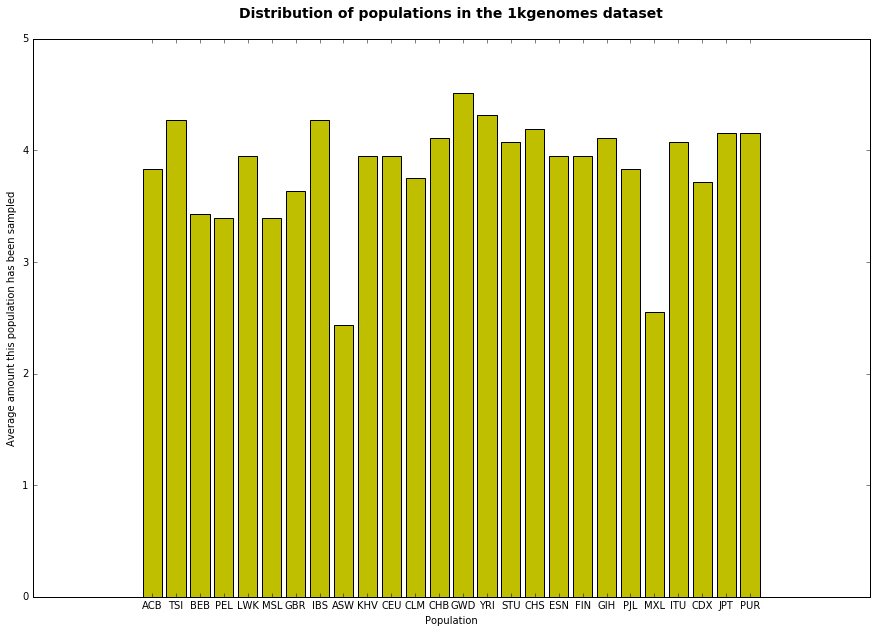

In [70]:
graph_population_map()

In [59]:
cluster_occurence()

{(u'CDX', 0): 3,
 (u'CDX', 1): 1,
 (u'CDX', 2): 5,
 (u'CDX', 3): 6,
 (u'CHS', 0): 32,
 (u'CHS', 1): 7,
 (u'CHS', 2): 29,
 (u'CHS', 3): 28,
 (u'CHS', 4): 9,
 (u'CLM', 0): 28,
 (u'CLM', 1): 3,
 (u'CLM', 2): 32,
 (u'CLM', 3): 16,
 (u'CLM', 4): 11,
 (u'FIN', 0): 24,
 (u'FIN', 1): 9,
 (u'FIN', 2): 30,
 (u'FIN', 3): 19,
 (u'FIN', 4): 16,
 (u'FIN', 5): 1,
 (u'GBR', 0): 24,
 (u'GBR', 1): 3,
 (u'GBR', 2): 29,
 (u'GBR', 3): 25,
 (u'GBR', 4): 6,
 (u'PUR', 0): 32,
 (u'PUR', 1): 4,
 (u'PUR', 2): 34,
 (u'PUR', 3): 21,
 (u'PUR', 4): 13}

# cluster_variant_matrix()

In [107]:
def cluster_variant_matrix(num_people, num_chrom, begin, stop, clusters):
    
    """
    performs similar operation to variant_matrix but with with k-means clustering data
    """
    
    csid_dict = {}    
    csid_dict = assign_labels_to_indexes(num_people, num_chrom, begin, stop, clusters)
    
    callMatrix = {}
    callMatrix = np.array(callMatrix)
    
    h = len(csid_dict)
    w = len(csid_dict)
    dimension = h*w
    
    callMatrix = [[0 for x in range(w)] for y in range(h)]    
    np.zeros((h,w))     
    #np.reshape(callMatrix, (h,w))
    
    vs = client.search_variants(variant_set_id, call_set_ids= call_set_ids[0:num_people],
           start=begin, end=stop, reference_name = num_chrom)

    for v in vs:
        for call_outer in v.calls:         
            for call_inner in v.calls:               
                outer_index = (csid_dict[call_outer.call_set_id])[1] 
                inner_index = (csid_dict[call_inner.call_set_id])[1]                             
                # can be 0 or 1
                A1 = call_outer.genotype[0] 
                A2 = call_outer.genotype[1]
                B1 = call_inner.genotype[0]
                B2 = call_inner.genotype[1]               
                # True for the shared genotype
                if (((A1 + A2 ) > 0) and ((B1 + B2) > 0)):
                    callMatrix[outer_index][inner_index] += 1
                elif (((A1 + A2 ) == 0) and ((B1 + B2) == 0)):
                    callMatrix[outer_index][inner_index] += 1               
                
    return (callMatrix)

In [110]:
def visualize_cluster_matrix_color(num_people, num_chrom, begin, stop, clusters):
    
    callMatrix = {}
    callMatrix = cluster_variant_matrix(num_people, num_chrom, begin, stop, clusters)
    
    
    fig = plt.figure(1,(10.,10.))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(1,1),
                    axes_pad=0.1)
    
    ax = grid[0]
    ax.set_title('Color matrix of variant clustering\n', fontsize=14, fontweight='bold')
    ax.set_xlabel("Individual's call set ids", fontsize=12)
    ax.set_ylabel("Individual's call set ids", fontsize=12)    
    ax.imshow(callMatrix, origin = "lower", interpolation="nearest")
    
    plt.show()


def visualize_cluster_matrix_grey(num_people, num_chrom, begin, stop, clusters):
        
    callMatrix = {}
    callMatrix = cluster_variant_matrix(num_people, num_chrom, begin, stop, clusters)
    
    fig = plt.figure(1,(10.,10.))
   
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(1,1),
                    axes_pad=0.1)
    ax = grid[0]  
    ax.set_title('Greyscale matrix of variant clustering\n', fontsize=14, fontweight='bold')
    ax.set_xlabel("Individual's call set ids", fontsize=12)
    ax.set_ylabel("Individual's call set ids", fontsize=12)
    
    ax.imshow(callMatrix, cmap= 'Greys', origin = "lower", interpolation="nearest")
    
 
    plt.show()

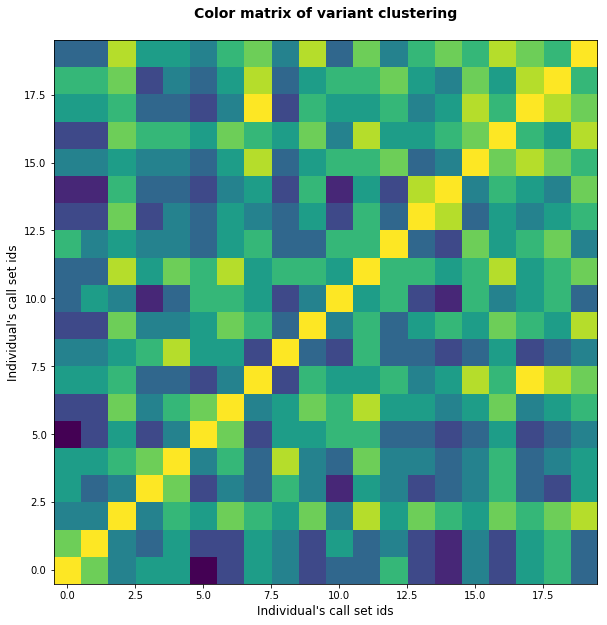

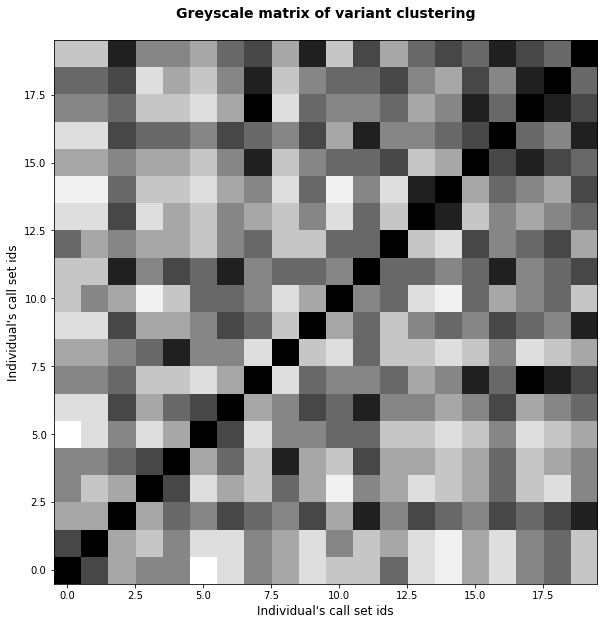

In [120]:
visualize_cluster_matrix_color(20, "1", 10000, 15000, 3)
visualize_cluster_matrix_grey(20, "1", 10000, 15000, 3)


# determine_matrix_range()

In [ ]:
def determine_matrix_range(matrix, num_people, num_chrom, begin, stop):
    
    """
    finds the range of shared variants in a given variant matrix 
    """
    
    matrix = {}
    matrix = variant_matrix(matrix, num_people, num_chrom, begin, stop)
    
    i = 0
    j = 0
    cur = 0
    lis = []
    
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            cur = matrix[i][j]
            lis.append(cur)
    minimum = 0
    maximum = 0 
    if (len(lis) > 0):        
        minimum = min(lis)
        maximum = max(lis)
    #print ("values in the matrix range from {} to {}".
    #       format(minimum, maximum))
    lis.sort()

    return lis

In [31]:
def find_percent_occurence(matrix, num_people, num_chrom, begin, stop):
    
    matrix_list = []
    matrix = {}
    matrix_list = determine_matrix_range(matrix, num_people, num_chrom, begin, stop)   
    i = 0
    key_list = []
    j = 0
    for i in matrix_list:
        variable = matrix_list[j]
        if (variable == i):
            key_list.append(variable)
            j += 1
        elif ( variable != i):
            j += 1
            
    occur_dict = {}
    occur_dict = occur_dict.fromkeys(key_list,0)
    i = 0
    j = 0  
    total = 0.0
    for i in matrix_list:
        variable = matrix_list[j]
        if ( i == variable):
            occur_dict[i] += 1
            j += 1
        elif ( i != variable):
            j += 1
        total += 1
    
    percent = 0.0
    for i in occur_dict:
        percent = ((occur_dict[i]/total)*100.0)
        occur_dict[i] = percent
    
    return occur_dict


In [33]:
def graph_percent_occurence(matrix, num_people, num_chrom, begin, stop):
    
    fig = plt.figure(1,(9.,9.))
    
    matrix = {}
    occur_dict = {}
    occur_dict = find_percent_occurence(matrix, num_people, num_chrom, begin, stop)
    
    occur_dict = collections.OrderedDict(sorted(occur_dict.items()))
    
    plt.bar(range(len(occur_dict)), occur_dict.values(), align='center')
    plt.xticks(range(len(occur_dict)), occur_dict.keys())
    
    ax = fig.add_subplot(111)
    ax.set_title('Distribution of shared variants among the genomic dataset (as compared to the reference genome)\n', fontsize=14, fontweight='bold')
    ax.set_xlabel('number of shared variants called within a range of bases on one chromosome')
    ax.set_ylabel('percent occurence of the amount of shared variants')
    plt.show()
    

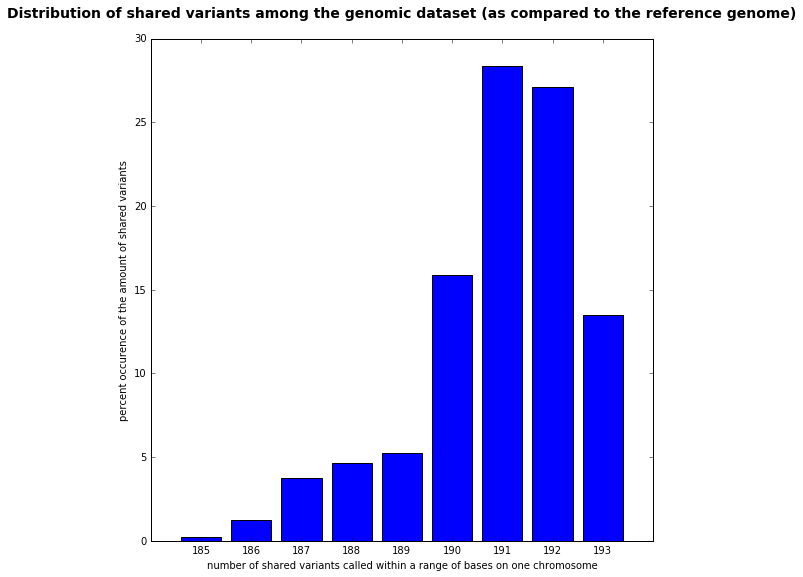

In [34]:
matrix = {}
graph_percent_occurence(matrix, 40, "1", 100000, 140000)

In [35]:
def mean_median_percent_occurence(matrix, num_people, num_chrom, begin, stop):
    
    matrix = {}
    occur_dict = {}
    occur_dict = find_percent_occurence(matrix, num_people, num_chrom, begin, stop)
    
    i = 0
    mean = 0.0
    median_index = 0
    for i in occur_dict:
        # print the dictionary of the percent occurence of shared variants 
        #print (i, occur_dict[i]) 
        mean += ((i*occur_dict[i])/100.0)
        median_index += 1
    
    median = 0.0
    if ((( median_index + 1) % 2) == 0 ):
        median_index += 1
        median_index /= 2        
        iter = 0
        i = 0
        for i in occur_dict:
            iter += 1
            if (iter == median_index):
                median = i
    elif ((median_index % 2) == 0):
        median_index /= 2
        median_neighbor = median_index + 1
        median_pair_index = (median_index, median_neighbor)
        iter1 = 0
        iter2 = 0
        i = 0
        for i in occur_dict:
            iter1 += 1
            iter2 += 1
            if ( iter1 == median_pair_index[0]):
                iter1 = i
                iter2 += 1
            if ( iter2 == median_pair_index[1]): 
                iter2 = i
                median = ((iter1 + iter2)/2)
                
    mean_median_pair = (mean, median)
    
    #print (mean_median_pair)
    return mean_median_pair

In [37]:
def analyze_matrix_intervals():
    callMatrix = {}
    start = 100000
    place = 105000
    stop = 1000000
    mean_median_pair_dict = {}
    val = 0
    while ( start != stop):
        mean_median_pair_dict[val] = mean_median_percent_occurence(callMatrix, 40, "1", start, place )     
        val += 1
        place += 5000
        start += 5000
        
       
    fig = plt.figure(1,(20.,10.))
    ylim(-1.0, 100.0)
         
    i = 0
    j = 0
    interval = 0
    plt.ion()
    for i,j in mean_median_pair_dict.values():  
        if ( interval != val):
            plt.scatter(interval, i, c= "blue", s=40) 
            plt.scatter(interval, j, c= "red", s=40) 
            plt.pause(0.05)
        if ( interval + 1 == val):
            plt.scatter(interval, i, c= "blue", s=40, label= "mean") 
            plt.scatter(interval, j, c= "red", s=40, label= "median") 
            plt.pause(0.05)        
        interval += 1  
        
    plt.plot(range(len(mean_median_pair_dict)), mean_median_pair_dict.values(), 'k')
    xlim(0, interval)
    plt.xticks(np.arange(interval))
  
    ax = fig.add_subplot(111)
    ax.set_title('Conservation of shared variants throughout 5000bp intervals\n', fontsize=14, fontweight='bold')
    ax.set_xlabel('interval')
    ax.set_ylabel('percent occurence of the amount of shared variants')
    ax.legend()


    plt.show()
               
    #return mean_median_pair_list

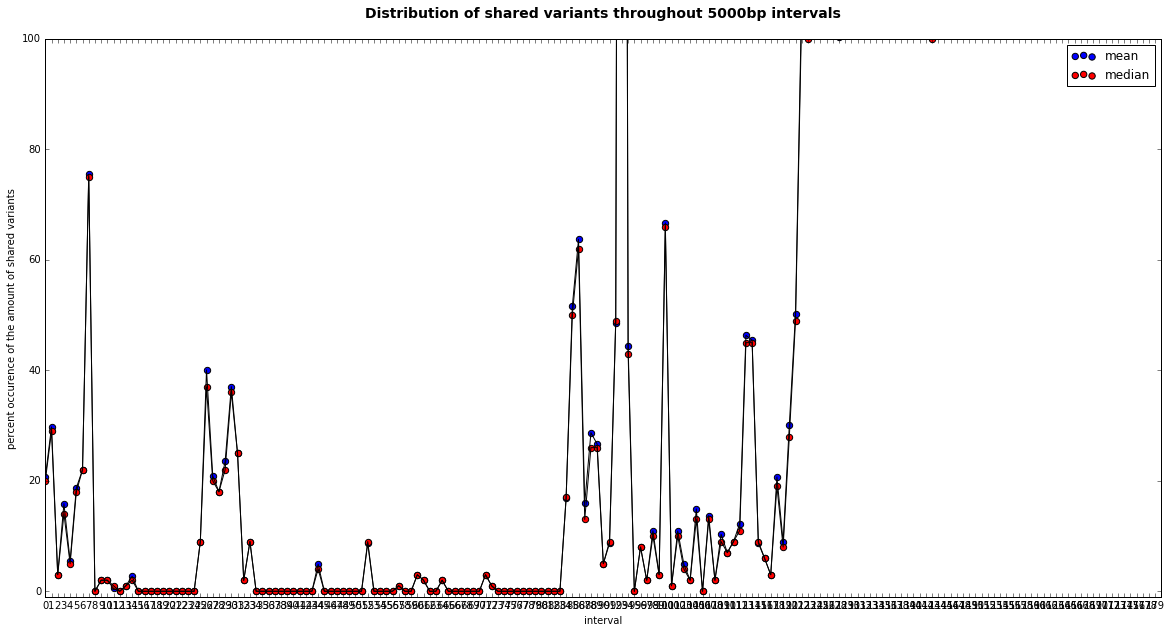

In [448]:
analyze_matrix_intervals()